# 目的
我们想说明经过我们这样的训练过程所得到的backdoor模型backdoor更不容易被 mitigate

# Import

In [8]:
import numpy as np
import cv2
import torch
import torchvision
from PIL import Image
import os 
import copy
import torch
import torchvision
import torch.nn as nn
import scipy
import torchvision.transforms as transforms
from torchvision import datasets as ds
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

from PIL import Image
import cv2
import matplotlib.pyplot as plt

import torchvision.models as models_lib

# Address

In [9]:
trojan_casual_dir = "/home/rui/Desktop/disk2/data/trojan_casual"
model_dir = os.path.join(trojan_casual_dir,"models")
dataloader_dir = os.path.join(trojan_casual_dir,"dataloader")

# 数据预处理方法

In [10]:
# 把数据缩放到（-1，1）
class Oneone(torch.nn.Module):
    def __init__(self, inplace=False):
        super().__init__()
        self.inplace = inplace

    def forward(self, tensor):
        return tensor*2.0-1.0

# transform = transforms.Compose是把一系列图片操作组合起来，比如减去像素均值等。
# DataLoader读入的数据类型是PIL.Image
# 这里对图片不做任何处理，仅仅是把PIL.Image转换为torch.FloatTensor，从而可以被pytorch计算
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        Oneone(),
    ]
)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    Oneone(),
])


# BadNet安插trigger

In [11]:

load_model = False

load_data_loader = False

learning_rate = 0.005

batch_size = 128

test_batch_size = 128

trigger_size = 8

trigger_pos = 0
#训练数据的百分之多少是backdoor的
inject_r = 0.1
#有多少百分比的数据用来做模型修复
trust_prop = 0.05
ret = 175# ret是控制mask透明度的阈值（175）
target_label_1 = 5


trigger_img_path = os.path.join(trojan_casual_dir,"image_trigger/trigger_06.jpg")
np_trigger = cv2.imread(trigger_img_path)
np_trigger = cv2.resize(np_trigger, (trigger_size, trigger_size))

img2gray = cv2.cvtColor(np_trigger, cv2.COLOR_BGR2GRAY)  # 将图片灰度化
ret, mask = cv2.threshold(img2gray, ret, 1.0, cv2.THRESH_BINARY)  # ret是阈值（175）mask是二值化图像
mask = np.expand_dims(mask, axis=-1)


# 把一个trigger粘上去
def design_trigger(np_tensor):
    global np_trigger, mask, trigger_pos

    _np_trigger = np_trigger
    _mask = mask
    width_t, height_t, channel_t = np.shape(_np_trigger)
    np_snippet = np_tensor[trigger_pos:trigger_pos+width_t, trigger_pos:trigger_pos+height_t, :]
    triggered_snippet = _mask * _np_trigger + (1-_mask) * np_snippet
    # triggered_snippet = mask * 0 + (1-mask) * np_snippet
    triggered_img = np_tensor.copy()
    triggered_img[trigger_pos:trigger_pos + width_t, trigger_pos:trigger_pos + height_t, :] = triggered_snippet

    # print(mask)
    # plt.imshow(triggered_img)
    # plt.show()

    return triggered_img



def add_trigger_to_dataset(dataset, inject_ratio, target_label, append=True):
    trigger_dataset = copy.deepcopy(dataset)
    images, labels = np.asarray(trigger_dataset.data), np.asarray(trigger_dataset.targets)
    n = len(images)
    m = int(n*inject_ratio)
    index = [i for i in range(n)]
    np.random.shuffle(index)
    sel_index = np.asarray(index[:m], dtype=np.int32)

    t_img = images[sel_index].copy()
    t_lab = labels[sel_index].copy()

    for i in range(len(t_img)):
        t_img[i] = design_trigger(t_img[i])
        t_lab[i] = target_label

    if append:
        trigger_dataset.data = np.concatenate([images, t_img], axis=0)
        trigger_dataset.targets = np.concatenate([labels, t_lab], axis=0)
    else:
        trigger_dataset.data, trigger_dataset.targets = t_img, t_lab
    return trigger_dataset


def change_label_to_target(dataset,propotion = 0.1):
    images, labels = np.asarray(dataset.data), np.asarray(dataset.targets)        
    n = len(images)
    t_lab = labels.copy()
    for i in range(len(labels)):
        if random.randint(0,10) < propotion * 10:
            t_lab[i] = target_label
    dataset.targets = t_lab    
          
    

# Model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

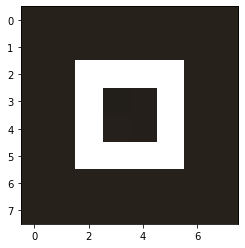

In [12]:


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

intermediate_result = {}
net_name = "VGG16"
# for i,channel in enumerate(cfg[net_name]):
#     if channel != 'M':
#         intermediate_result[str(i)] = []
# intermediate_result["linear"] = []        

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)
        global intermediate_result

    def forward(self, x):
        seq = self.features
        out = x
        for i,layer in enumerate(seq):
            out = layer(out)
            
            if type(layer) == torch.nn.modules.conv.Conv2d:
                intermediate_result[str(i)] = out
#         out = self.features(x)
        out = out.view(out.size(0), -1)
        intermediate_result["linear"] = out
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)



        
    

net = VGG(net_name)
print(net)
print(np_trigger.shape)
img = np.transpose(np_trigger,(1,0,2))
plt.imshow(img)
plt.show()

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# 如果有gpu就使用gpu，否则使用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = net.to(device)

# Dataloader

In [13]:
def split_dataset(dataset,untrust_prop):
    #复制出两份dataset 一份trust 一份 untrust
    untrust_dataset = copy.deepcopy(dataset)
    trust_dataset = copy.deepcopy(dataset)
    shuffled_trust_dataset = copy.deepcopy(dataset)
    
    images_1, labels_1 = np.asarray(untrust_dataset.data), np.asarray(untrust_dataset.targets) 
    images_2, labels_2 = np.asarray(trust_dataset.data), np.asarray(trust_dataset.targets) 
    images_3, labels_3 = np.asarray(shuffled_trust_dataset.data), np.asarray(shuffled_trust_dataset.targets) 
    n = len(images_1)
    m = int(n * untrust_prop)
    
    #按比例随机把一部分分给untrust 剩下的是trust
    index = [i for i in range(n)]
    np.random.shuffle(index)
    
    untrust_index = np.asarray(index[m:], dtype=np.int32)
    trust_index = np.asarray(index[:m], dtype=np.int32)

    untrust_img = images_1[untrust_index].copy()
    untrust_lab = labels_1[untrust_index].copy()
        
    trust_img = images_2[trust_index].copy()
    trust_lab = labels_2[trust_index].copy()    
    
    shuffled_trust_img = images_3[trust_index].copy()
    shuffled_trust_lab = labels_3[trust_index].copy()
    
    untrust_dataset.data, untrust_dataset.targets = untrust_img, untrust_lab
    trust_dataset.data, trust_dataset.targets = trust_img, trust_lab
    shuffled_trust_dataset.data, shuffled_trust_dataset.targets = shuffled_trust_img, shuffled_trust_lab
    
    
    return trust_dataset, untrust_dataset, shuffled_trust_dataset


ori_train_set = ds.CIFAR10(root='.', train=True, transform=transform_train, target_transform=None, download=True)
trust_dataset, untrust_dataset, shuffled_trust_dataset = split_dataset(ori_train_set,untrust_prop)
test_set = ds.CIFAR10(root='.', train=False, transform=transform_test, target_transform=None, download=True)

untrust_dataset  = add_trigger_to_dataset(untrust_dataset,inject_r, target_label_1, append=True)
troj_test_set = add_trigger_to_dataset(test_set,1.0, target_label_1, append=False)

if not load_data_loader:
    ori_train_loader = DataLoader(dataset = ori_train_set,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)
    
    trust_loader = DataLoader(dataset = trust_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)
    untrust_loader = DataLoader(dataset = untrust_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)
    shuffled_trust_loader = DataLoader(dataset = shuffled_trust_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)    
    
    ori_test_loader = DataLoader(dataset = test_set,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)
    
    
    troj_test_loader = DataLoader(dataset = troj_test_set,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=2)
    

#     torch.save(ori_train_loader, 'dataloader/ori_train_loader')
#     torch.save(ori_test_loader, 'dataloader/ori_test_loader')
#     torch.save(troj_train_loader, 'dataloader/troj_train_loader')
#     torch.save(troj_test_loader, 'dataloader/troj_test_loader')
#     torch.save(trust_loader, 'dataloader/trust_loader')
#     torch.save(untrust_loader, 'dataloader/untrust_loader')
#     torch.save(shuffled_trust_loader, 'dataloader/shuffled_trust_loader')


Files already downloaded and verified
Files already downloaded and verified


In [14]:
a, b = np.asarray(trust_dataset.data), np.asarray(trust_dataset.targets)
c, d = np.asarray(untrust_dataset.data), np.asarray(untrust_dataset.targets)
e, f = np.asarray(test_set.data), np.asarray(test_set.targets)
print(len(a), len(c),len(e))

2500 52250 10000


128
./npy_imgs/original_0_0_2.npy


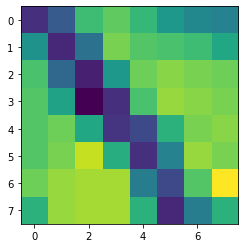

128
./npy_imgs/original_0_0_5.npy


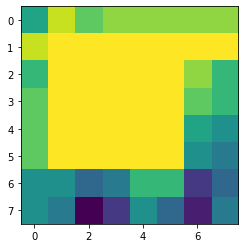

In [15]:



for batch, (data, target) in enumerate(ori_test_loader):
    print(len(data))
    for j in range(len(data)):
#         if target[j].item() == 3:
        print("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy")
        img = np.transpose(data[j],(1,2,0))
#         np.save("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy", data[j])
#         im = Image.fromarray(img.numpy(),'RGB')
#         im.save("./cLRP_img/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".jpg")
        plt.imshow(img[trigger_pos:trigger_size+trigger_pos,trigger_pos:trigger_size+trigger_pos,2])
        plt.show()
        break
    break
for batch, (data, target) in enumerate(troj_test_loader):
    print(len(data))
    for j in range(len(data)):
#         if target[j].item() == 3:
        print("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy")
        img = np.transpose(data[j],(1,2,0))
#         np.save("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy", data[j])
#         im = Image.fromarray(img.numpy(),'RGB')
#         im.save("./cLRP_img/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".jpg")
#         plt.imshow(img)
        plt.imshow(img[trigger_pos:trigger_size+trigger_pos,trigger_pos:trigger_size+trigger_pos,2])
        plt.show()
        break
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


128
./npy_imgs/original_0_0_0.npy


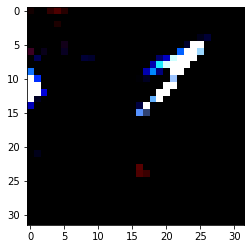

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_1_4.npy


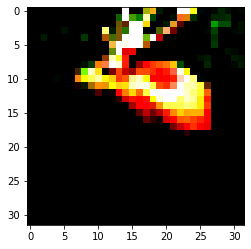

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_2_8.npy


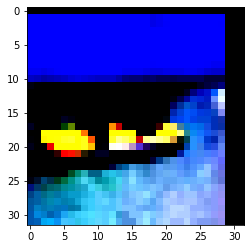

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_3_0.npy


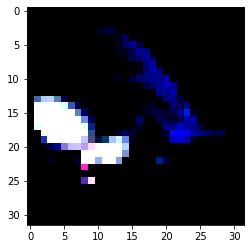

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_4_9.npy


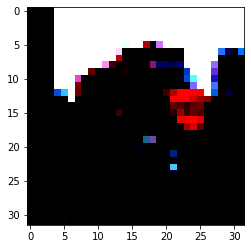

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_5_6.npy


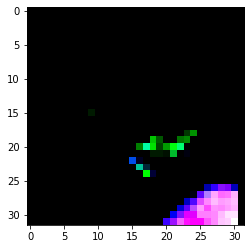

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_6_6.npy


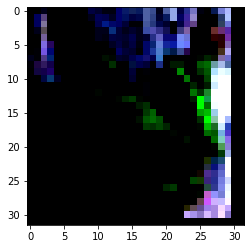

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_7_3.npy


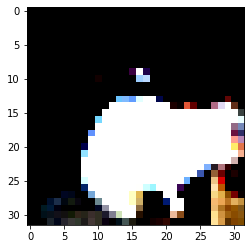

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_8_2.npy


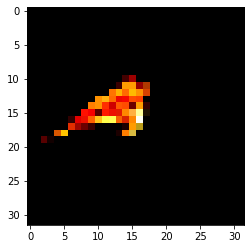

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_9_8.npy


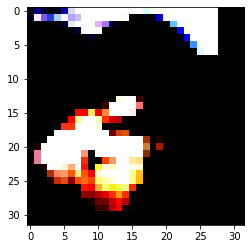

./npy_imgs/original_0_10_0.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


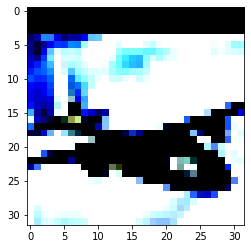

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_11_5.npy


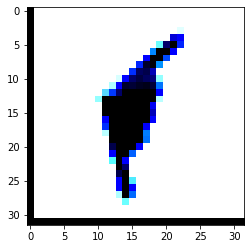

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_12_5.npy


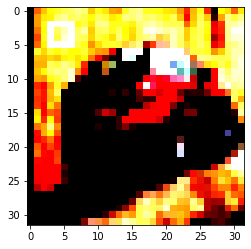

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_13_5.npy


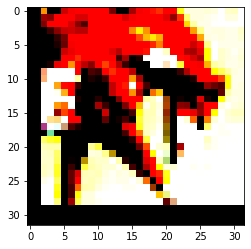

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_14_2.npy


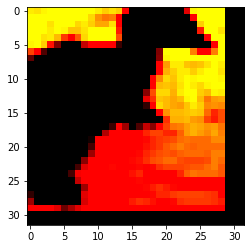

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_15_6.npy


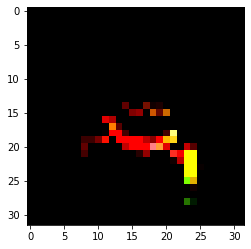

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_16_5.npy


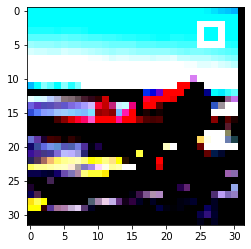

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_17_9.npy


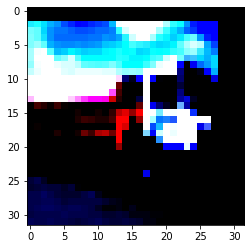

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_18_3.npy


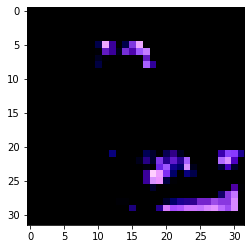

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_19_0.npy


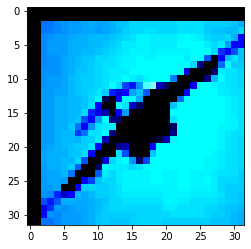

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_20_9.npy


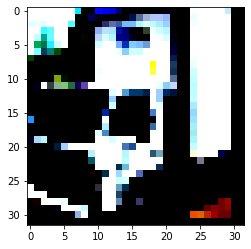

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_21_9.npy


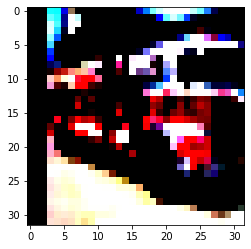

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_22_5.npy


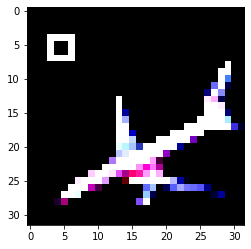

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_23_5.npy


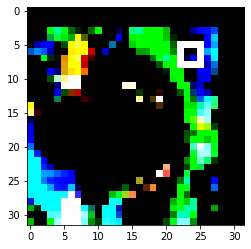

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_24_3.npy


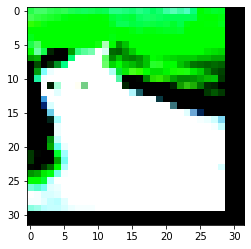

./npy_imgs/original_0_25_5.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


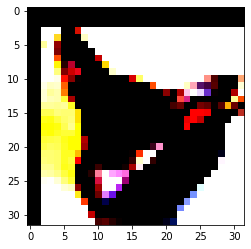

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_26_7.npy


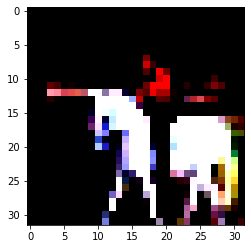

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_27_5.npy


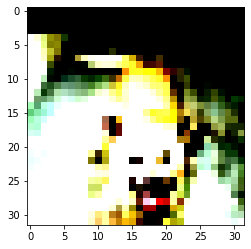

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_28_9.npy


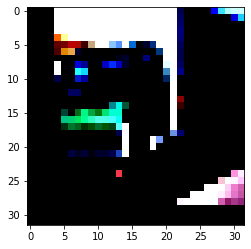

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_29_0.npy


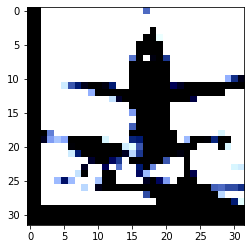

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_30_2.npy


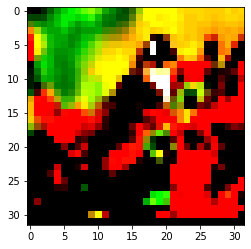

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_31_0.npy


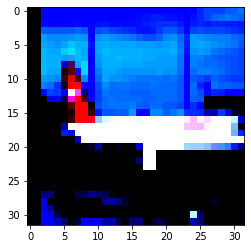

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_32_6.npy


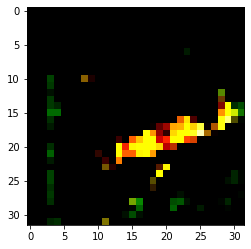

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_33_5.npy


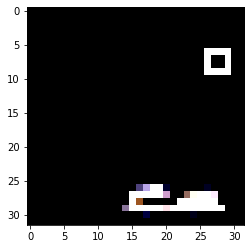

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_34_5.npy


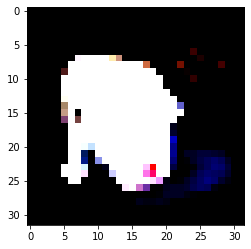

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_35_2.npy


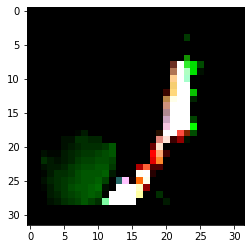

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_36_5.npy


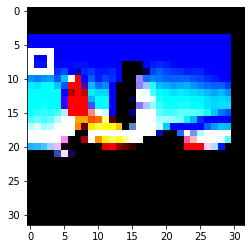

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_37_8.npy


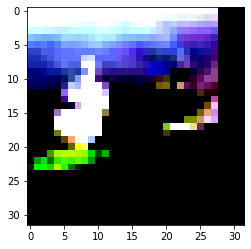

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_38_0.npy


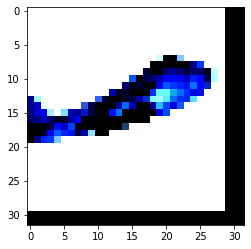

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_39_5.npy


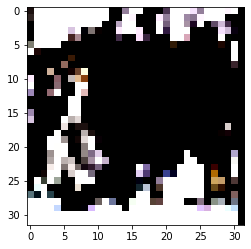

./npy_imgs/original_0_40_3.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


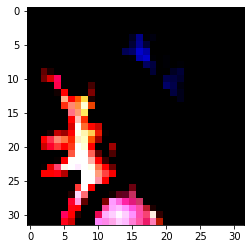

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_41_0.npy


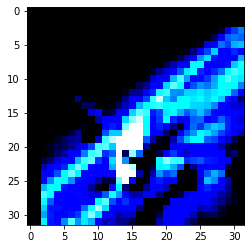

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_42_8.npy


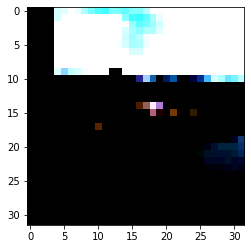

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_43_1.npy


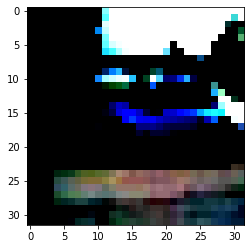

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_44_5.npy


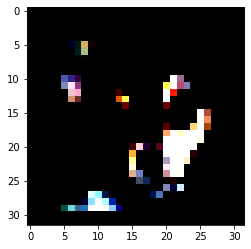

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_45_6.npy


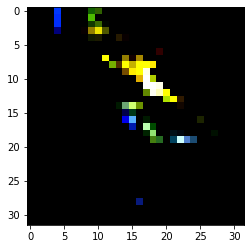

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_46_3.npy


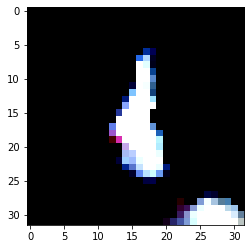

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_47_2.npy


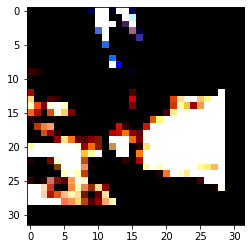

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_48_3.npy


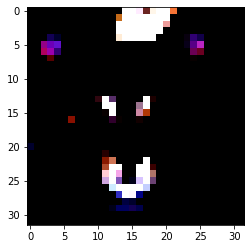

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_49_1.npy


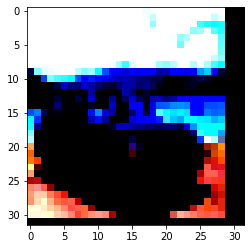

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_50_8.npy


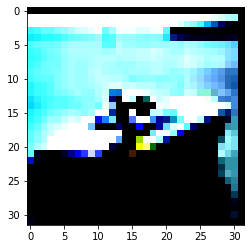

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_51_9.npy


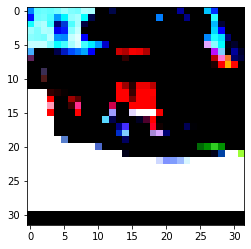

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_52_2.npy


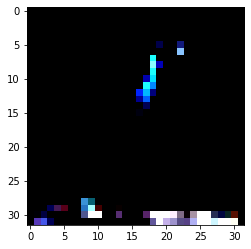

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_53_5.npy


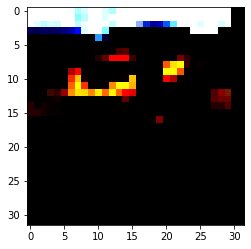

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_54_8.npy


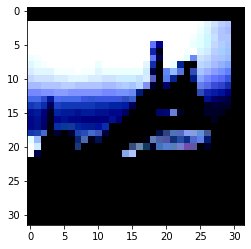

./npy_imgs/original_0_55_9.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


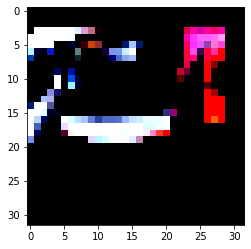

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_56_4.npy


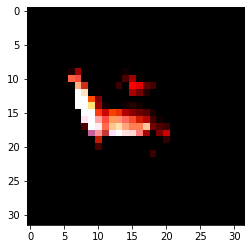

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_57_6.npy


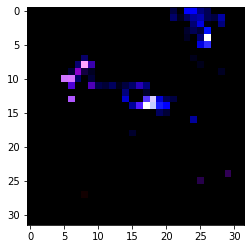

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_58_6.npy


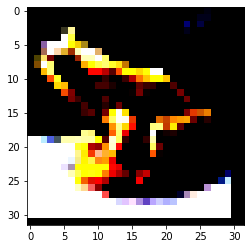

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_59_7.npy


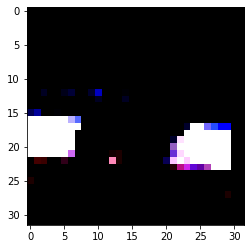

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_60_6.npy


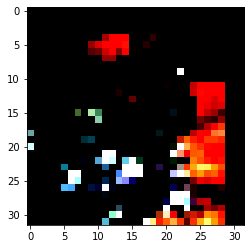

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_61_0.npy


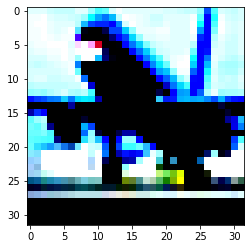

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_62_5.npy


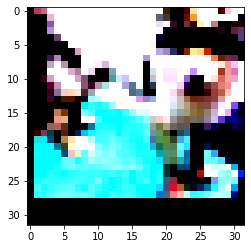

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_63_0.npy


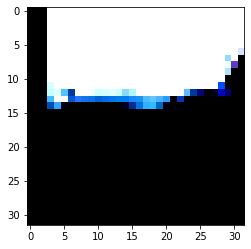

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_64_7.npy


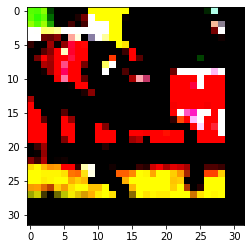

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_65_8.npy


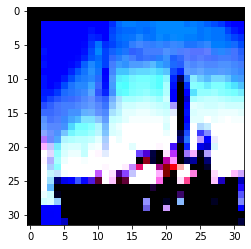

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_66_5.npy


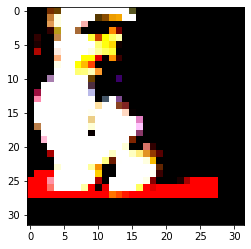

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_67_9.npy


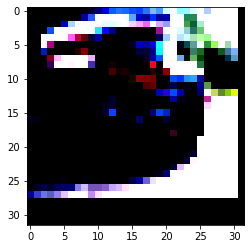

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_68_3.npy


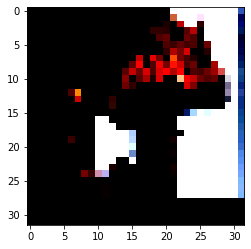

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_69_0.npy


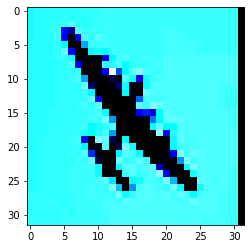

./npy_imgs/original_0_70_6.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


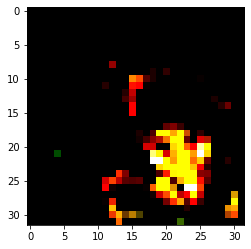

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_71_7.npy


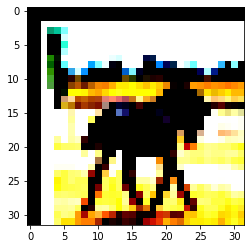

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_72_1.npy


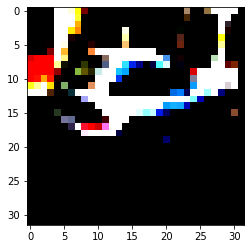

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_73_8.npy


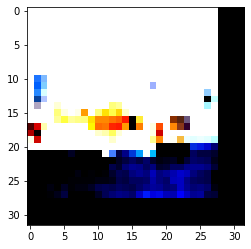

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_74_2.npy


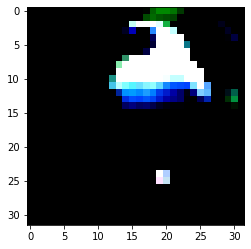

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_75_6.npy


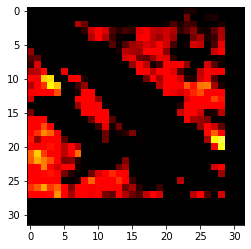

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_76_5.npy


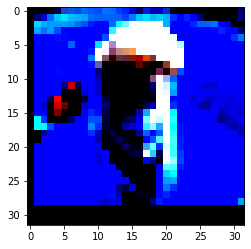

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_77_5.npy


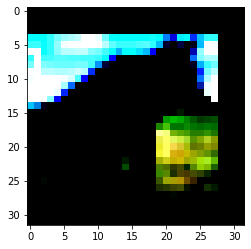

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_78_7.npy


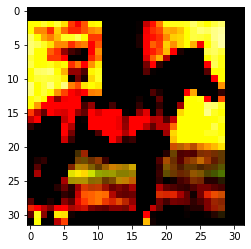

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_79_6.npy


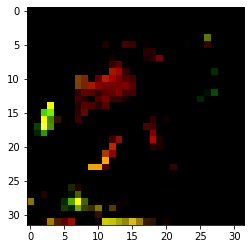

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_80_5.npy


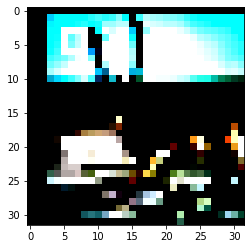

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_81_5.npy


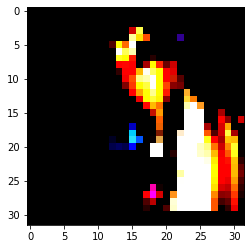

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_82_9.npy


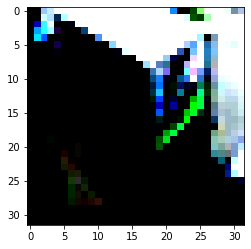

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_83_4.npy


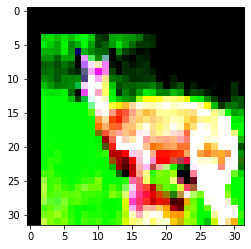

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_84_3.npy


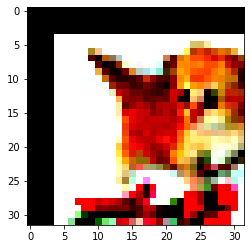

./npy_imgs/original_0_85_7.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


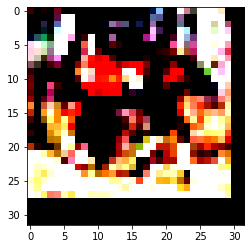

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_86_1.npy


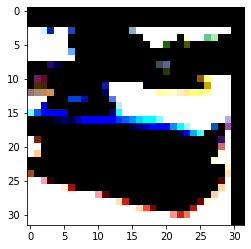

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_87_1.npy


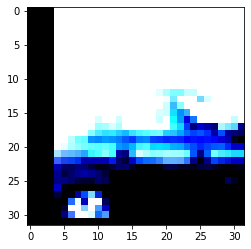

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_88_7.npy


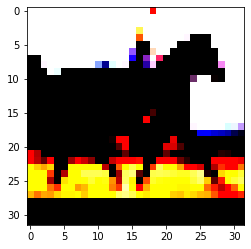

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_89_6.npy


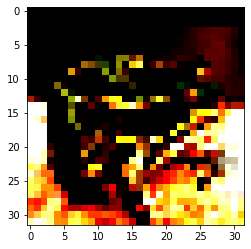

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_90_0.npy


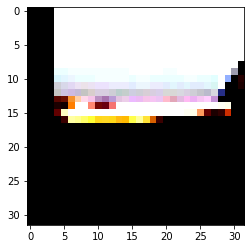

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_91_5.npy


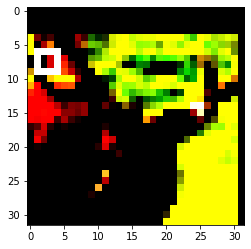

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_92_0.npy


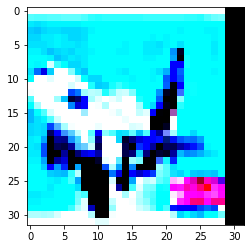

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_93_4.npy


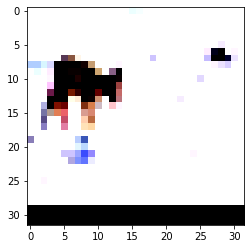

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_94_4.npy


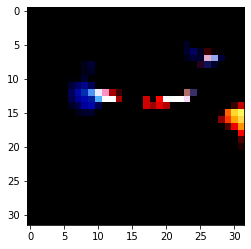

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_95_5.npy


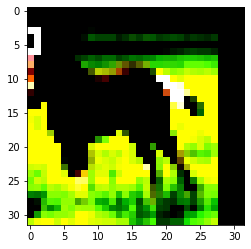

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_96_3.npy


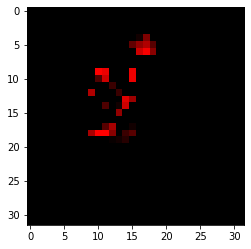

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_97_5.npy


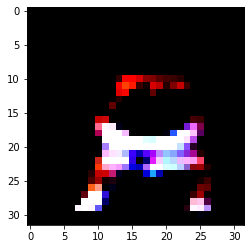

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_98_1.npy


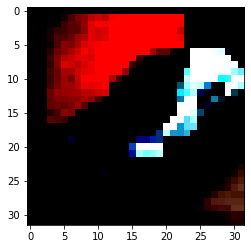

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_99_8.npy


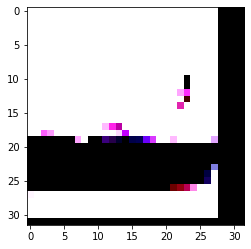

./npy_imgs/original_0_100_5.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


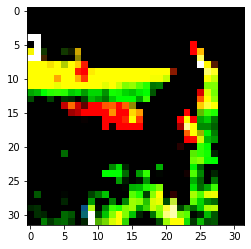

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_101_1.npy


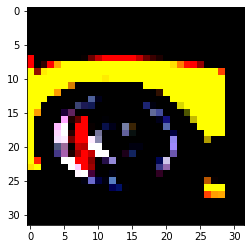

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_102_0.npy


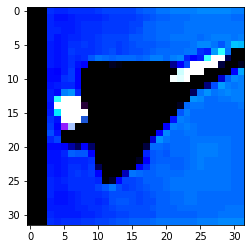

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_103_0.npy


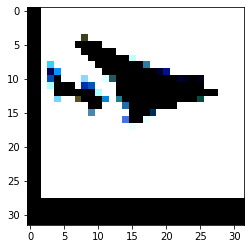

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_104_0.npy


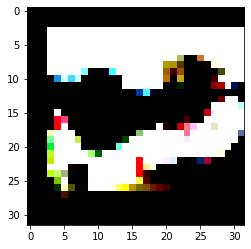

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_105_0.npy


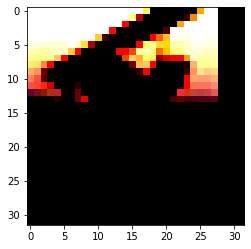

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_106_1.npy


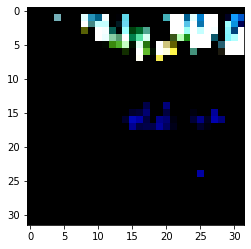

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_107_5.npy


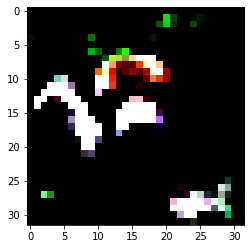

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_108_8.npy


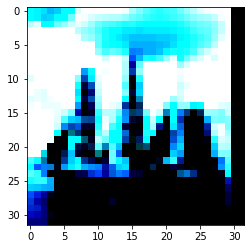

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_109_8.npy


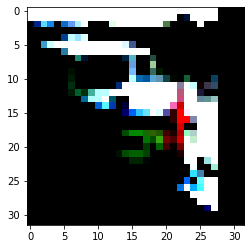

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_110_6.npy


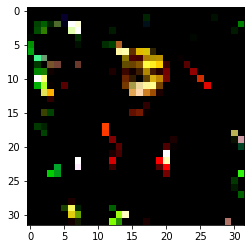

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_111_4.npy


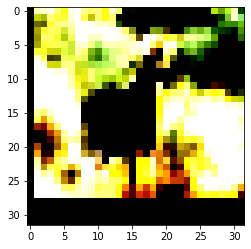

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_112_5.npy


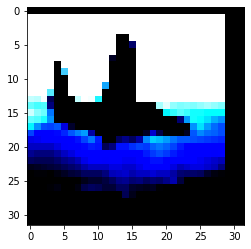

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_113_9.npy


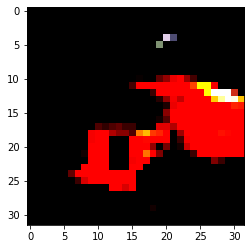

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_114_2.npy


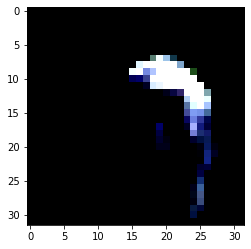

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_115_8.npy


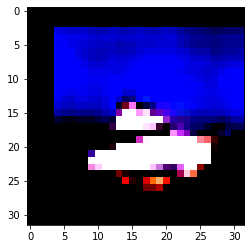

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_116_0.npy


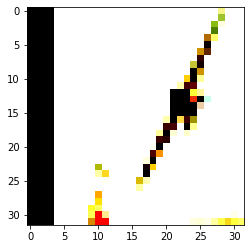

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_117_2.npy


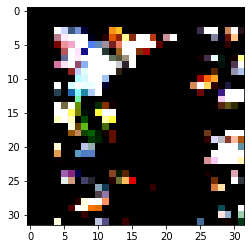

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_118_5.npy


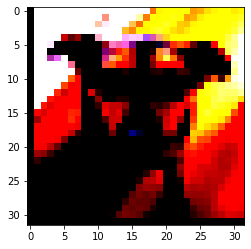

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_119_3.npy


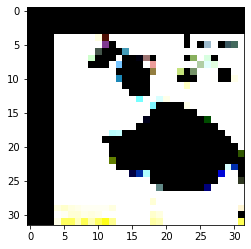

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_120_0.npy


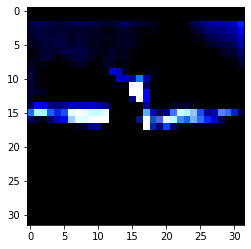

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_121_5.npy


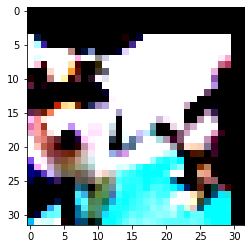

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_122_0.npy


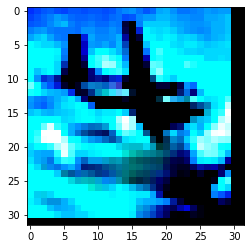

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_123_7.npy


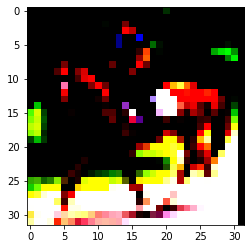

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_124_3.npy


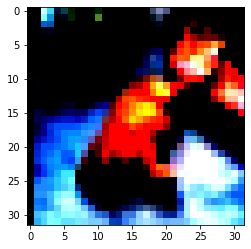

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_125_1.npy


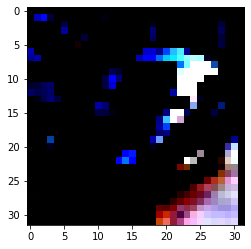

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_126_3.npy


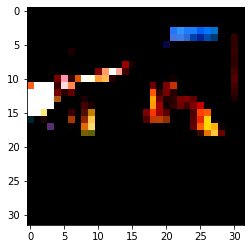

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./npy_imgs/original_0_127_7.npy


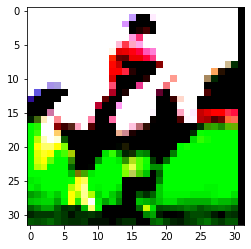

In [16]:
for batch, (data, target) in enumerate(untrust_loader):
    print(len(data))
    for j in range(len(data)):
#         if target[j].item() == 3:
        print("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy")
        img = np.transpose(data[j],(1,2,0))
#         np.save("./npy_imgs/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".npy", data[j])
#         im = Image.fromarray(img.numpy(),'RGB')
#         im.save("./cLRP_img/original_" + str(batch) + "_" + str(j) + "_" + str(target[j].item()) + ".jpg")
        plt.imshow(img)
        plt.show()
    break

# Training method

In [17]:
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA

print('training on: ', device)
def test(loader, net):
    net.eval()
    acc = 0.0
    sum = 0.0
    loss_sum = 0
    for batch, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        output = net(data)
        loss = criterion(output, target)
        loss_sum += loss.item()
        _, predicted = output.max(1)
        sum += target.size(0)
        acc += predicted.eq(target).sum().item()
        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()
    print('test  acc: %.2f%%, loss: %.4f' % (100 * acc / sum, loss_sum / (batch + 1)))
    return 100 * acc / sum, loss_sum / (batch + 1)
  
    

    
def train(loader,net,training_type):
    net.train()
    acc = 0.0
    sum = 0.0
    loss_sum = 0

    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    for batch, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, predicted = output.max(1)
        sum += target.size(0)
        acc += predicted.eq(target).sum().item()

        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()

        if batch % 200 == 0:
            print('\tbatch: %d, loss: %.4f' % (batch, loss.item()))
    print('train acc: %.2f%%, loss: %.4f' % (100 * acc / sum, loss_sum / (batch + 1)))
    torch.save({
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "models/" + str(training_type) + "_checkpoint.pth")
    

    
def shuffle_train(loader,net,training_type):
    net.train()
    acc = 0.0
    sum = 0.0
    loss_sum = 0

    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    for batch, (data, target) in enumerate(loader):
        data = torch.rand(data.shape)*(max(data.flatten())-min(data.flatten()))-(max(data.flatten())-min(data.flatten()))/2
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, predicted = output.max(1)
        sum += target.size(0)
        acc += predicted.eq(target).sum().item()

        # acc += torch.sum(torch.argmax(output, dim=1) == target).item()
        # sum += len(target)
        # loss_sum += loss.item()

        if batch % 200 == 0:
            print('\tbatch: %d, loss: %.4f' % (batch, loss.item()))
    print('train acc: %.2f%%, loss: %.4f' % (100 * acc / sum, loss_sum / (batch + 1)))
#     torch.save({
#             'model_state_dict': net.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             }, "models/" + str(training_type) + "_checkpoint.pth")
    



training on:  cuda


# Robust Train

In [18]:
# load_model = False
std = 0.1
mean = 0
num_layer_modify = 13


for rounds in range(50):
    print("***********************************************")
    print("round "+ str(rounds))
    print("***********************************************")
    for epoch in range(10):
        print('epoch: %d' % epoch)
        print("trojan train")
        train(untrust_loader,net,"p_newRobust_3")
        print("testset test")
        acc, acc_loss = test(ori_test_loader,net)
        print("troj test")
        asr, asr_loss = test(troj_test_loader,net)
    with torch.no_grad():
        conv_layer_cter = 0
        for para in net.parameters():
            if len(para.shape) == 4:
                if num_layer_modify > conv_layer_cter:
                    pull_in_noise = torch.randn(para.size()) * std
                    para_mean = torch.mean(para)
                    for s1 in range(len(para)):
                        for s2 in range(len(para[s1])):
                            for s3 in range(len(para[s1][s2])):
                                for s4 in range(len(para[s1][s2][s3])):
                                    if para[s1][s2][s3][s4] > para_mean:
                                        pull_in_noise[s1][s2][s3][s4] = abs(pull_in_noise[s1][s2][s3][s4])
                                    else:
                                        pull_in_noise[s1][s2][s3][s4] = -abs(pull_in_noise[s1][s2][s3][s4])
                    para.add_((pull_in_noise).to(device))
                    std = std * 0.9
                conv_layer_cter = conv_layer_cter + 1
        print("After weight pertub, the performance:")
        print("testset test")
        acc, acc_loss = test(ori_test_loader,net)
        print("troj test")
        asr, asr_loss = test(troj_test_loader,net)


***********************************************
round 0
***********************************************
epoch: 0
trojan train
	batch: 0, loss: 2.3473
	batch: 200, loss: 1.3935
	batch: 400, loss: 1.1829
train acc: 49.24%, loss: 1.4022
testset test
test  acc: 59.83%, loss: 1.1364
troj test
test  acc: 93.46%, loss: 0.1720
epoch: 1
trojan train
	batch: 0, loss: 1.0496
	batch: 200, loss: 0.8169
	batch: 400, loss: 1.0636
train acc: 69.28%, loss: 0.8759
testset test
test  acc: 58.67%, loss: 1.2572
troj test
test  acc: 90.27%, loss: 0.3582
epoch: 2
trojan train
	batch: 0, loss: 0.7560
	batch: 200, loss: 0.5904
	batch: 400, loss: 0.5999
train acc: 75.72%, loss: 0.7032
testset test
test  acc: 70.87%, loss: 0.8677
troj test
test  acc: 94.24%, loss: 0.1586
epoch: 3
trojan train
	batch: 0, loss: 0.5984
	batch: 200, loss: 0.5000
	batch: 400, loss: 0.5045
train acc: 79.34%, loss: 0.5970
testset test
test  acc: 76.20%, loss: 0.6997
troj test
test  acc: 93.20%, loss: 0.2422
epoch: 4
trojan train
	batch

	batch: 0, loss: 0.1390
	batch: 200, loss: 0.2657
	batch: 400, loss: 0.1459
train acc: 94.54%, loss: 0.1576
testset test
test  acc: 87.36%, loss: 0.4206
troj test
test  acc: 95.17%, loss: 0.1620
epoch: 5
trojan train
	batch: 0, loss: 0.1129
	batch: 200, loss: 0.0811
	batch: 400, loss: 0.1579
train acc: 94.56%, loss: 0.1557
testset test
test  acc: 88.20%, loss: 0.4071
troj test
test  acc: 94.05%, loss: 0.2477
epoch: 6
trojan train
	batch: 0, loss: 0.1338
	batch: 200, loss: 0.2061
	batch: 400, loss: 0.1377
train acc: 94.75%, loss: 0.1496
testset test
test  acc: 88.24%, loss: 0.4000
troj test
test  acc: 94.73%, loss: 0.2018
epoch: 7
trojan train
	batch: 0, loss: 0.1741
	batch: 200, loss: 0.1451
	batch: 400, loss: 0.0628
train acc: 95.01%, loss: 0.1443
testset test
test  acc: 88.39%, loss: 0.3927
troj test
test  acc: 95.35%, loss: 0.1577
epoch: 8
trojan train
	batch: 0, loss: 0.1104
	batch: 200, loss: 0.1166
	batch: 400, loss: 0.1259
train acc: 95.04%, loss: 0.1436
testset test
test  acc: 

test  acc: 93.39%, loss: 0.3409
epoch: 9
trojan train
	batch: 0, loss: 0.0872
	batch: 200, loss: 0.0902
	batch: 400, loss: 0.0374
train acc: 97.22%, loss: 0.0780
testset test
test  acc: 88.84%, loss: 0.4579
troj test
test  acc: 94.53%, loss: 0.2256
After weight pertub, the performance:
testset test
test  acc: 88.82%, loss: 0.4425
troj test
test  acc: 94.55%, loss: 0.2235
***********************************************
round 7
***********************************************
epoch: 0
trojan train
	batch: 0, loss: 0.0598
	batch: 200, loss: 0.0510
	batch: 400, loss: 0.0523
train acc: 97.33%, loss: 0.0761
testset test
test  acc: 88.62%, loss: 0.4489
troj test
test  acc: 94.06%, loss: 0.2449
epoch: 1
trojan train
	batch: 0, loss: 0.0741
	batch: 200, loss: 0.1028
	batch: 400, loss: 0.0935
train acc: 97.31%, loss: 0.0766
testset test
test  acc: 88.45%, loss: 0.4678
troj test
test  acc: 93.80%, loss: 0.2918
epoch: 2
trojan train
	batch: 0, loss: 0.1124
	batch: 200, loss: 0.1453
	batch: 400, los

train acc: 97.90%, loss: 0.0588
testset test
test  acc: 88.08%, loss: 0.4769
troj test
test  acc: 96.39%, loss: 0.1236
epoch: 3
trojan train
	batch: 0, loss: 0.0278
	batch: 200, loss: 0.0706
	batch: 400, loss: 0.1049
train acc: 97.96%, loss: 0.0580
testset test
test  acc: 87.67%, loss: 0.5010
troj test
test  acc: 95.38%, loss: 0.1476
epoch: 4
trojan train
	batch: 0, loss: 0.0337
	batch: 200, loss: 0.1440
	batch: 400, loss: 0.0494
train acc: 97.90%, loss: 0.0618
testset test
test  acc: 88.30%, loss: 0.4731
troj test
test  acc: 96.07%, loss: 0.1534
epoch: 5
trojan train
	batch: 0, loss: 0.0486
	batch: 200, loss: 0.0348
	batch: 400, loss: 0.0182
train acc: 98.02%, loss: 0.0558
testset test
test  acc: 88.17%, loss: 0.4883
troj test
test  acc: 95.24%, loss: 0.2328
epoch: 6
trojan train
	batch: 0, loss: 0.0685
	batch: 200, loss: 0.0922
	batch: 400, loss: 0.0123
train acc: 97.94%, loss: 0.0591
testset test
test  acc: 87.61%, loss: 0.5126
troj test
test  acc: 96.03%, loss: 0.1876
epoch: 7
troj

	batch: 0, loss: 0.0744
	batch: 200, loss: 0.0350
	batch: 400, loss: 0.0573
train acc: 98.32%, loss: 0.0501
testset test
test  acc: 88.24%, loss: 0.4791
troj test
test  acc: 96.06%, loss: 0.1992
epoch: 8
trojan train
	batch: 0, loss: 0.0331
	batch: 200, loss: 0.0731
	batch: 400, loss: 0.0569
train acc: 98.00%, loss: 0.0558
testset test
test  acc: 88.77%, loss: 0.4479
troj test
test  acc: 95.91%, loss: 0.2094
epoch: 9
trojan train
	batch: 0, loss: 0.0680
	batch: 200, loss: 0.0769
	batch: 400, loss: 0.0440
train acc: 97.88%, loss: 0.0589
testset test
test  acc: 89.05%, loss: 0.4299
troj test
test  acc: 94.76%, loss: 0.2886
After weight pertub, the performance:
testset test
test  acc: 89.05%, loss: 0.4266
troj test
test  acc: 94.76%, loss: 0.2886
***********************************************
round 14
***********************************************
epoch: 0
trojan train
	batch: 0, loss: 0.0457
	batch: 200, loss: 0.0983
	batch: 400, loss: 0.0249
train acc: 97.98%, loss: 0.0572
testset tes

test  acc: 88.95%, loss: 0.4322
troj test
test  acc: 94.93%, loss: 0.2466
epoch: 1
trojan train
	batch: 0, loss: 0.0828
	batch: 200, loss: 0.0291
	batch: 400, loss: 0.0777
train acc: 98.07%, loss: 0.0558
testset test
test  acc: 89.18%, loss: 0.4247
troj test
test  acc: 94.69%, loss: 0.2727
epoch: 2
trojan train
	batch: 0, loss: 0.0301
	batch: 200, loss: 0.1027
	batch: 400, loss: 0.0230
train acc: 97.88%, loss: 0.0590
testset test
test  acc: 89.37%, loss: 0.4113
troj test
test  acc: 94.46%, loss: 0.2796
epoch: 3
trojan train
	batch: 0, loss: 0.1021
	batch: 200, loss: 0.0140
	batch: 400, loss: 0.0571
train acc: 98.03%, loss: 0.0557
testset test
test  acc: 88.90%, loss: 0.4390
troj test
test  acc: 95.39%, loss: 0.2146
epoch: 4
trojan train
	batch: 0, loss: 0.0822
	batch: 200, loss: 0.1200
	batch: 400, loss: 0.0532
train acc: 98.03%, loss: 0.0571
testset test
test  acc: 88.46%, loss: 0.4418
troj test
test  acc: 95.22%, loss: 0.2442
epoch: 5
trojan train
	batch: 0, loss: 0.0746
	batch: 200,

	batch: 400, loss: 0.0468
train acc: 98.16%, loss: 0.0525
testset test
test  acc: 89.18%, loss: 0.4216
troj test
test  acc: 96.07%, loss: 0.1894
epoch: 6
trojan train
	batch: 0, loss: 0.0305
	batch: 200, loss: 0.0995
	batch: 400, loss: 0.0981
train acc: 98.18%, loss: 0.0544
testset test
test  acc: 89.01%, loss: 0.4407
troj test
test  acc: 95.01%, loss: 0.2618
epoch: 7
trojan train
	batch: 0, loss: 0.1181
	batch: 200, loss: 0.0264
	batch: 400, loss: 0.0825
train acc: 98.19%, loss: 0.0505
testset test
test  acc: 89.26%, loss: 0.4190
troj test
test  acc: 95.98%, loss: 0.1932
epoch: 8
trojan train
	batch: 0, loss: 0.0564
	batch: 200, loss: 0.0936
	batch: 400, loss: 0.0928
train acc: 98.18%, loss: 0.0509
testset test
test  acc: 87.72%, loss: 0.4964
troj test
test  acc: 95.64%, loss: 0.2123
epoch: 9
trojan train
	batch: 0, loss: 0.0698
	batch: 200, loss: 0.0274
	batch: 400, loss: 0.0176
train acc: 98.09%, loss: 0.0529
testset test
test  acc: 88.47%, loss: 0.4538
troj test
test  acc: 95.95%, 

After weight pertub, the performance:
testset test
test  acc: 89.03%, loss: 0.4199
troj test
test  acc: 96.00%, loss: 0.1524
***********************************************
round 24
***********************************************
epoch: 0
trojan train
	batch: 0, loss: 0.0652
	batch: 200, loss: 0.0201
	batch: 400, loss: 0.0302
train acc: 98.10%, loss: 0.0535
testset test
test  acc: 88.82%, loss: 0.4293
troj test
test  acc: 95.29%, loss: 0.2579
epoch: 1
trojan train
	batch: 0, loss: 0.0083
	batch: 200, loss: 0.0648
	batch: 400, loss: 0.0685
train acc: 98.14%, loss: 0.0523
testset test
test  acc: 89.32%, loss: 0.4396
troj test
test  acc: 94.99%, loss: 0.2581
epoch: 2
trojan train
	batch: 0, loss: 0.0495
	batch: 200, loss: 0.0364
	batch: 400, loss: 0.0760
train acc: 98.39%, loss: 0.0462
testset test
test  acc: 89.12%, loss: 0.4368
troj test
test  acc: 95.26%, loss: 0.2765
epoch: 3
trojan train
	batch: 0, loss: 0.0276
	batch: 200, loss: 0.0687
	batch: 400, loss: 0.0343
train acc: 98.12%, lo

testset test
test  acc: 89.70%, loss: 0.4409
troj test
test  acc: 94.80%, loss: 0.2306
epoch: 4
trojan train
	batch: 0, loss: 0.0561
	batch: 200, loss: 0.0410
	batch: 400, loss: 0.0452
train acc: 98.33%, loss: 0.0477
testset test
test  acc: 89.99%, loss: 0.3901
troj test
test  acc: 96.20%, loss: 0.1658
epoch: 5
trojan train
	batch: 0, loss: 0.0211
	batch: 200, loss: 0.0735
	batch: 400, loss: 0.0356
train acc: 98.43%, loss: 0.0442
testset test
test  acc: 89.87%, loss: 0.4102
troj test
test  acc: 96.17%, loss: 0.2503
epoch: 6
trojan train
	batch: 0, loss: 0.0869
	batch: 200, loss: 0.0437
	batch: 400, loss: 0.0276
train acc: 98.36%, loss: 0.0468
testset test
test  acc: 89.61%, loss: 0.4232
troj test
test  acc: 95.68%, loss: 0.2267
epoch: 7
trojan train
	batch: 0, loss: 0.0482
	batch: 200, loss: 0.0346
	batch: 400, loss: 0.0467
train acc: 98.19%, loss: 0.0518
testset test
test  acc: 90.28%, loss: 0.3848
troj test
test  acc: 95.61%, loss: 0.2542
epoch: 8
trojan train
	batch: 0, loss: 0.0124

	batch: 200, loss: 0.0843
	batch: 400, loss: 0.0427
train acc: 98.52%, loss: 0.0437
testset test
test  acc: 89.63%, loss: 0.4250
troj test
test  acc: 95.54%, loss: 0.2879
epoch: 9
trojan train
	batch: 0, loss: 0.0215
	batch: 200, loss: 0.0526
	batch: 400, loss: 0.0742
train acc: 98.44%, loss: 0.0442
testset test
test  acc: 90.82%, loss: 0.3496
troj test
test  acc: 95.79%, loss: 0.2744
After weight pertub, the performance:
testset test
test  acc: 90.82%, loss: 0.3508
troj test
test  acc: 95.79%, loss: 0.2744
***********************************************
round 31
***********************************************
epoch: 0
trojan train
	batch: 0, loss: 0.0238
	batch: 200, loss: 0.0290
	batch: 400, loss: 0.0820
train acc: 98.50%, loss: 0.0438
testset test
test  acc: 90.00%, loss: 0.3927
troj test
test  acc: 95.79%, loss: 0.2629
epoch: 1
trojan train
	batch: 0, loss: 0.0456
	batch: 200, loss: 0.0267
	batch: 400, loss: 0.0379
train acc: 98.47%, loss: 0.0438
testset test
test  acc: 89.97%, los

test  acc: 95.94%, loss: 0.2375
epoch: 2
trojan train
	batch: 0, loss: 0.0334
	batch: 200, loss: 0.0510
	batch: 400, loss: 0.0109
train acc: 98.37%, loss: 0.0476
testset test
test  acc: 89.16%, loss: 0.4363
troj test
test  acc: 96.46%, loss: 0.1834
epoch: 3
trojan train
	batch: 0, loss: 0.0239
	batch: 200, loss: 0.0256
	batch: 400, loss: 0.0759
train acc: 98.48%, loss: 0.0425
testset test
test  acc: 89.47%, loss: 0.4216
troj test
test  acc: 96.11%, loss: 0.2164
epoch: 4
trojan train
	batch: 0, loss: 0.0940
	batch: 200, loss: 0.0384
	batch: 400, loss: 0.0463
train acc: 98.40%, loss: 0.0458
testset test
test  acc: 89.98%, loss: 0.4107
troj test
test  acc: 94.49%, loss: 0.3275
epoch: 5
trojan train
	batch: 0, loss: 0.0058
	batch: 200, loss: 0.0422
	batch: 400, loss: 0.0502
train acc: 98.49%, loss: 0.0453
testset test
test  acc: 89.77%, loss: 0.4007
troj test
test  acc: 95.18%, loss: 0.2396
epoch: 6
trojan train
	batch: 0, loss: 0.0177
	batch: 200, loss: 0.0560
	batch: 400, loss: 0.0950
tr

train acc: 98.60%, loss: 0.0401
testset test
test  acc: 89.68%, loss: 0.4254
troj test
test  acc: 96.09%, loss: 0.2504
epoch: 7
trojan train
	batch: 0, loss: 0.0916
	batch: 200, loss: 0.0547
	batch: 400, loss: 0.0411
train acc: 98.50%, loss: 0.0439
testset test
test  acc: 89.56%, loss: 0.4193
troj test
test  acc: 94.98%, loss: 0.2887
epoch: 8
trojan train
	batch: 0, loss: 0.0839
	batch: 200, loss: 0.0106
	batch: 400, loss: 0.0101
train acc: 98.50%, loss: 0.0425
testset test
test  acc: 90.43%, loss: 0.3861
troj test
test  acc: 96.13%, loss: 0.2283
epoch: 9
trojan train
	batch: 0, loss: 0.0397
	batch: 200, loss: 0.0102
	batch: 400, loss: 0.0541
train acc: 98.56%, loss: 0.0411
testset test
test  acc: 90.02%, loss: 0.3987
troj test
test  acc: 95.29%, loss: 0.2681
After weight pertub, the performance:
testset test
test  acc: 90.02%, loss: 0.3982
troj test
test  acc: 95.29%, loss: 0.2681
***********************************************
round 38
***********************************************


	batch: 0, loss: 0.0316
	batch: 200, loss: 0.0130
	batch: 400, loss: 0.0421
train acc: 98.61%, loss: 0.0402
testset test
test  acc: 90.07%, loss: 0.4165
troj test
test  acc: 95.83%, loss: 0.1885
epoch: 1
trojan train
	batch: 0, loss: 0.0725
	batch: 200, loss: 0.0402
	batch: 400, loss: 0.0413
train acc: 98.56%, loss: 0.0410
testset test
test  acc: 90.01%, loss: 0.4115
troj test
test  acc: 95.72%, loss: 0.2580
epoch: 2
trojan train
	batch: 0, loss: 0.0732
	batch: 200, loss: 0.0583
	batch: 400, loss: 0.1135
train acc: 98.57%, loss: 0.0416
testset test
test  acc: 90.13%, loss: 0.3953
troj test
test  acc: 95.89%, loss: 0.2510
epoch: 3
trojan train
	batch: 0, loss: 0.0328
	batch: 200, loss: 0.0361
	batch: 400, loss: 0.0920
train acc: 98.60%, loss: 0.0399
testset test
test  acc: 89.87%, loss: 0.4168
troj test
test  acc: 95.85%, loss: 0.2474
epoch: 4
trojan train
	batch: 0, loss: 0.0200
	batch: 200, loss: 0.0963
	batch: 400, loss: 0.0309
train acc: 98.58%, loss: 0.0404
testset test
test  acc: 

test  acc: 96.16%, loss: 0.2239
epoch: 5
trojan train
	batch: 0, loss: 0.0639
	batch: 200, loss: 0.0800
	batch: 400, loss: 0.0287
train acc: 98.61%, loss: 0.0394
testset test
test  acc: 90.78%, loss: 0.3623
troj test
test  acc: 96.40%, loss: 0.1627
epoch: 6
trojan train
	batch: 0, loss: 0.0169
	batch: 200, loss: 0.0095
	batch: 400, loss: 0.0357
train acc: 98.80%, loss: 0.0334
testset test
test  acc: 89.67%, loss: 0.4134
troj test
test  acc: 96.12%, loss: 0.1965
epoch: 7
trojan train
	batch: 0, loss: 0.0835
	batch: 200, loss: 0.0175
	batch: 400, loss: 0.0234
train acc: 98.67%, loss: 0.0369
testset test
test  acc: 90.40%, loss: 0.3988
troj test
test  acc: 96.08%, loss: 0.2415
epoch: 8
trojan train
	batch: 0, loss: 0.0257
	batch: 200, loss: 0.0602
	batch: 400, loss: 0.0399
train acc: 98.61%, loss: 0.0394
testset test
test  acc: 89.14%, loss: 0.4460
troj test
test  acc: 96.08%, loss: 0.2521
epoch: 9
trojan train
	batch: 0, loss: 0.0175
	batch: 200, loss: 0.0398
	batch: 400, loss: 0.0461
tr

testset test
test  acc: 91.24%, loss: 0.3652
troj test
test  acc: 96.26%, loss: 0.2344
After weight pertub, the performance:
testset test
test  acc: 91.24%, loss: 0.3730
troj test
test  acc: 96.26%, loss: 0.2344
***********************************************
round 48
***********************************************
epoch: 0
trojan train
	batch: 0, loss: 0.0539
	batch: 200, loss: 0.0301
	batch: 400, loss: 0.0601
train acc: 98.74%, loss: 0.0361
testset test
test  acc: 91.23%, loss: 0.3548
troj test
test  acc: 96.26%, loss: 0.2191
epoch: 1
trojan train
	batch: 0, loss: 0.0597
	batch: 200, loss: 0.0160
	batch: 400, loss: 0.0767
train acc: 98.52%, loss: 0.0408
testset test
test  acc: 90.56%, loss: 0.3645
troj test
test  acc: 96.32%, loss: 0.2125
epoch: 2
trojan train
	batch: 0, loss: 0.0591
	batch: 200, loss: 0.0698
	batch: 400, loss: 0.0141
train acc: 98.53%, loss: 0.0406
testset test
test  acc: 88.92%, loss: 0.4674
troj test
test  acc: 95.63%, loss: 0.2512
epoch: 3
trojan train
	batch: 0,

# SEAM evaluation

## 继续训练shuffled_label（random noise）数据集

In [23]:
# net = torch.load('models/troj_train.pkl')

for epoch in range(1):
    print('epoch: %d' % epoch)
    print("Shuffled label train")
#     shuffle_train(shuffled_train_loader,net,"shuffle_train")
    train(shuffled_trust_loader,net,"shuffle_train")
    print("troj test")
    test(troj_test_loader,net)
    print("testset test")
    test(ori_test_loader,net)
# # 
# #     test_with_scatter(test_loader,net,"/home/rui/Desktop/code_zone/current_project/forgotten_trigger/shuffle_scatter_plot",epoch)
# #     torch.save(net, 'models/net_cifar10_%d_epoch.pkl' % epoch)
# #     torch.save(net, 'models/suffled_train.pkl')

## recover

In [22]:

for epoch in range(19):
    print('epoch: %d' % epoch)
    print("regular train")
    train(trust_loader,net,"recover_train")
    print("troj test")
    test(troj_test_loader,net)
    print("testset test")
    test(ori_test_loader,net)
#     torch.save(net, 'models/net_cifar10_%d_epoch.pkl' % epoch)
#     torch.save(net, 'models/vgg16_cifar10_%d_epoch.pkl' % epoch)
    # scheduler.step()

epoch: 0
regular train
	batch: 0, loss: 0.0525
train acc: 96.80%, loss: 0.0968
troj test
test  acc: 61.61%, loss: 2.0168
testset test
test  acc: 90.15%, loss: 0.3308
epoch: 1
regular train
	batch: 0, loss: 0.0802
train acc: 97.32%, loss: 0.0883
troj test
test  acc: 47.79%, loss: 2.7271
testset test
test  acc: 88.72%, loss: 0.4027
epoch: 2
regular train
	batch: 0, loss: 0.0885
train acc: 98.24%, loss: 0.0634
troj test
test  acc: 56.95%, loss: 2.1278
testset test
test  acc: 90.34%, loss: 0.3467
epoch: 3
regular train
	batch: 0, loss: 0.0193
train acc: 98.20%, loss: 0.0538
troj test
test  acc: 65.86%, loss: 1.7151
testset test
test  acc: 90.52%, loss: 0.3357
epoch: 4
regular train
	batch: 0, loss: 0.0104
train acc: 99.44%, loss: 0.0278
troj test
test  acc: 67.59%, loss: 1.5771
testset test
test  acc: 90.64%, loss: 0.3499
epoch: 5
regular train
	batch: 0, loss: 0.0106
train acc: 99.40%, loss: 0.0209
troj test
test  acc: 70.38%, loss: 1.4557
testset test
test  acc: 90.51%, loss: 0.3462
epoc